In [122]:
import os
import imp
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import sys
import pickle as plk
import importlib.util
import scipy.optimize

###############################################################
# LINUX PATH

sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
import lumapi
sys.path.append(os.path.dirname('/home/fotonica04/Documentos/GitHub/Photonics-training/Projects/Hybrid4x4/InterconnectFiles')) #Current directory


###############################################################
# WINDOWS PATH

# spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
# lumapi = importlib.util.module_from_spec(spec_win)
# os.add_dll_directory("C:/Program Files/Lumerical/v202/api/python")
# sys.path.append(os.path.dirname('C:/Users/Caio/Documents/GitHub/Photonics-training/Projects/Hybrid4x4/InterconnectFiles/'))
# spec_win.loader.exec_module(lumapi)

## Lumapi init

In [123]:
mmi = lumapi.INTERCONNECT(filename='Hybrid4x4.icp')

## Functions

In [450]:
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess, bounds=([-np.inf,-np.inf,-np.inf,-np.inf], [np.inf, np.inf, np.inf, np.inf]))
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    #return A
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

def linear(t,a,b):
    return a*t + b

dict_keys(['time', 'amplitude (a.u.)', 'Lumerical_dataset'])


(0.19, 0.2)

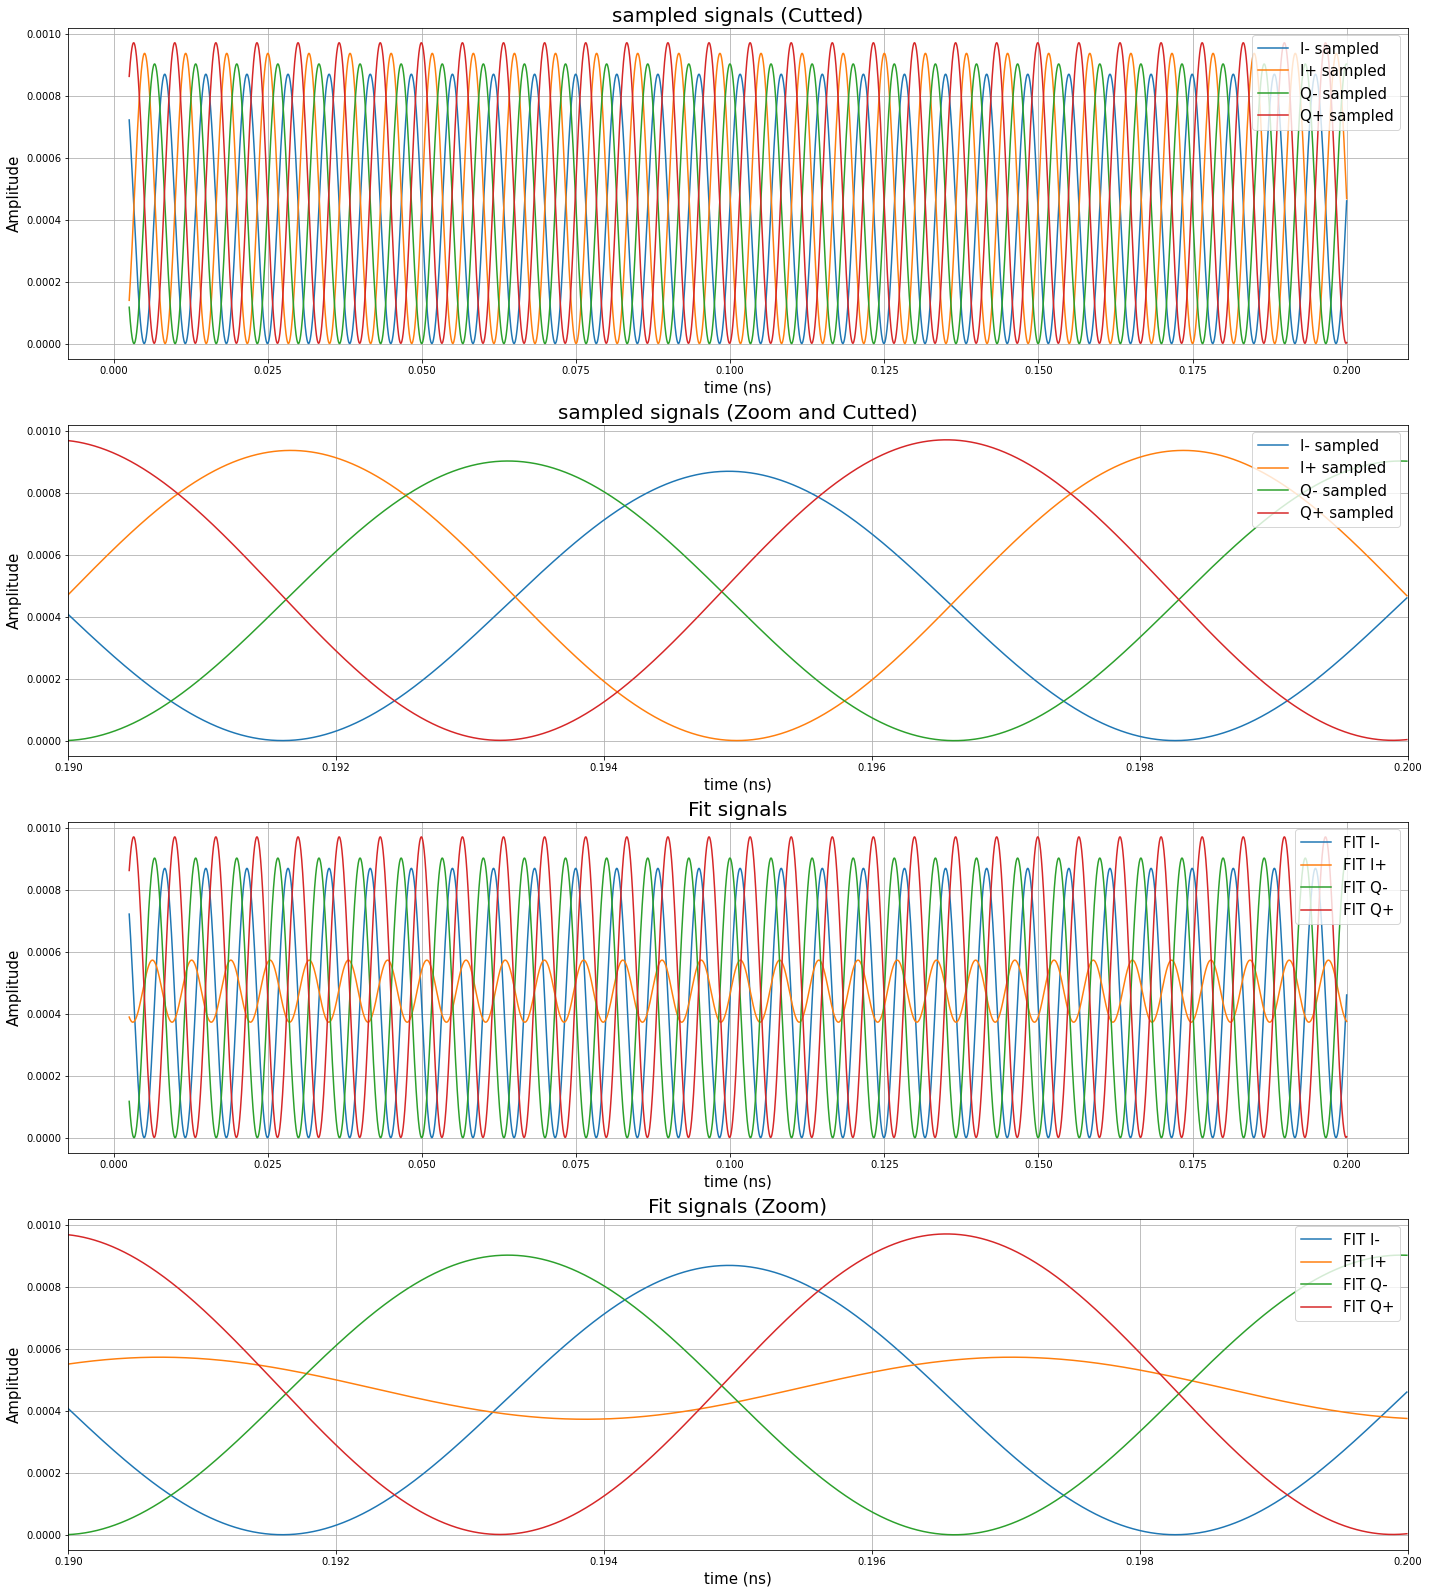

In [447]:
#getFreq = mmi.get('sample rate')
#Cut = int(4e-10 * getFreq/3)
Cut = 500

Result_IN = mmi.getresult('OSC_1', 'signal')
Result_QP = mmi.getresult('OSC_2', 'signal')
Result_QN = mmi.getresult('OSC_3', 'signal')
Result_IP = mmi.getresult('OSC_4', 'signal')
time = Result_IN['time']
print(Result_IN.keys())

IN_sampled = Result_IN['amplitude (a.u.)']
IP_sampled = Result_IP['amplitude (a.u.)']
QN_sampled = Result_QN['amplitude (a.u.)']
QP_sampled = Result_QP['amplitude (a.u.)']
t = np.ndarray.flatten(time[Cut:])

IN = np.ndarray.flatten(IN_sampled[Cut:])
IP = np.ndarray.flatten(IP_sampled[Cut:])
QN = np.ndarray.flatten(QN_sampled[Cut:])
QP = np.ndarray.flatten(QP_sampled[Cut:])
c = 299792458

fig, ax= plt.subplots(4,1,figsize=(24,28))
ax[0].plot(time[Cut:]*1e9, IN_sampled[Cut:], label = 'I- sampled')
ax[0].plot(time[Cut:]*1e9, IP_sampled[Cut:], label = 'I+ sampled')
ax[0].plot(time[Cut:]*1e9, QN_sampled[Cut:], label = 'Q- sampled')
ax[0].plot(time[Cut:]*1e9, QP_sampled[Cut:], label = 'Q+ sampled')
#plt.xlim([0, 1])
ax[0].grid(True)
ax[0].set_xlabel('time (ns)',fontsize =15)
ax[0].set_ylabel('Amplitude',fontsize =15)
ax[0].set_title('sampled signals (Cutted)',fontsize =20)
ax[0].legend(loc = 'upper right',fontsize =15)

ax[1].plot(time[Cut:]*1e9, IN_sampled[Cut:], label = 'I- sampled')
ax[1].plot(time[Cut:]*1e9, IP_sampled[Cut:], label = 'I+ sampled')
ax[1].plot(time[Cut:]*1e9, QN_sampled[Cut:], label = 'Q- sampled')
ax[1].plot(time[Cut:]*1e9, QP_sampled[Cut:], label = 'Q+ sampled')
#plt.xlim([0, 1])
ax[1].grid(True)
ax[1].set_xlabel('time (ns)',fontsize =15)
ax[1].set_ylabel('Amplitude',fontsize =15)
ax[1].set_title('sampled signals (Zoom and Cutted)',fontsize =20)
ax[1].legend(loc = 'upper right',fontsize =15)
ax[1].set_xlim(0.19 , 0.20)

fit_IN = fit_sin(t, IN)
fit_IP = fit_sin(t, IP)
fit_QN = fit_sin(t, QN)
fit_QP = fit_sin(t, QP)

ax[2].plot(time[Cut:]*1e9, fit_IN['amp']*np.sin(2*np.pi*fit_IN['freq']*t+fit_IN['phase'])+fit_IN['offset'], label = 'FIT I-')
ax[2].plot(time[Cut:]*1e9, fit_IP['amp']*np.sin(2*np.pi*fit_IP['freq']*t+fit_IP['phase'])+fit_IP['offset'], label = 'FIT I+')
ax[2].plot(time[Cut:]*1e9, fit_QN['amp']*np.sin(2*np.pi*fit_QN['freq']*t+fit_QN['phase'])+fit_QN['offset'], label = 'FIT Q-')
ax[2].plot(time[Cut:]*1e9, fit_QP['amp']*np.sin(2*np.pi*fit_QP['freq']*t+fit_QP['phase'])+fit_QP['offset'], label = 'FIT Q+')
ax[2].grid(True)
ax[2].set_xlabel('time (ns)',fontsize =15)
ax[2].set_ylabel('Amplitude',fontsize =15)
ax[2].set_title('Fit signals',fontsize =20)
ax[2].legend(loc = 'upper right',fontsize =15)

ax[3].plot(time[Cut:]*1e9, fit_IN['amp']*np.sin(2*np.pi*fit_IN['freq']*t+fit_IN['phase'])+fit_IN['offset'], label = 'FIT I-')
ax[3].plot(time[Cut:]*1e9, fit_IP['amp']*np.sin(2*np.pi*fit_IP['freq']*t+fit_IP['phase'])+fit_IP['offset'], label = 'FIT I+')
ax[3].plot(time[Cut:]*1e9, fit_QN['amp']*np.sin(2*np.pi*fit_QN['freq']*t+fit_QN['phase'])+fit_QN['offset'], label = 'FIT Q-')
ax[3].plot(time[Cut:]*1e9, fit_QP['amp']*np.sin(2*np.pi*fit_QP['freq']*t+fit_QP['phase'])+fit_QP['offset'], label = 'FIT Q+')
ax[3].grid(True)
ax[3].set_xlabel('time (ns)',fontsize =15)
ax[3].set_ylabel('Amplitude',fontsize =15)
ax[3].set_title('Fit signals (Zoom)',fontsize =20)
ax[3].legend(loc = 'upper right',fontsize =15)
ax[3].set_xlim(0.19 , 0.20)

In [442]:
dataFrame = pd.DataFrame(np.array([[fit_IN['phase']*180/np.pi, fit_IN['amp'], fit_IN['freq']*1e-12], 
                                   [fit_IP['phase']*180/np.pi, fit_IP['amp'], fit_IP['freq']*1e-12], 
                                   [fit_QN['phase']*180/np.pi, fit_QN['amp'], fit_QN['freq']*1e-12],
                                   [fit_QP['phase']*180/np.pi, fit_QP['amp'], fit_QP['freq']*1e-12]]),
                                 columns=['Phase (°)', 'Amplitude', 'Frequency (THz)'],
                                 index=['IN', 'IP', 'QN', 'QP'])
dataFrame

def style_negative(v, props=''):
    return props if v < 0 else None

dataFrame.style \
  .format_index(str.upper, axis=1) \
  .applymap(style_negative, props='color:red;', subset="Amplitude") \
  .set_properties(**{
    'font-size': '15pt',
  })

,PHASE (°),AMPLITUDE,FREQUENCY (THZ)
IN,-72.048047,0.000425,0.430000
IP,56.742981,-0.000001,0.430380
QN,16.029199,0.000442,0.430000
QP,19.449491,-0.000479,0.430000


In [255]:
c = 299792458
Freqer = abs(c/(1530e-9+5.5e-9) - c/1530e-9)
print(Freqer*1e-12)

mmi.switchtodesign()
mmi.set('sample rate',1e12+Freqer*100)

0.7018465037680938


## Sweep

Text(0, 0.5, 'phase difference (degree)')

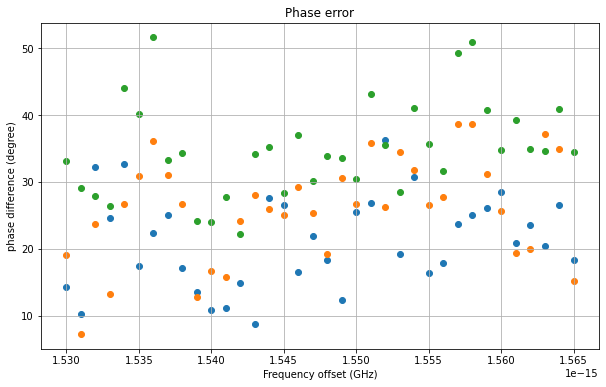

In [452]:
c = 299792458
CFreqArray = np.arange(1530e-9, 1565e-9, 1e-9)
#CFreqArray = np.array([1560e-9])
LaserArray = np.arange(0.5e-9 , 25e-9, 0.5e-9) # Prototype Laser Array
PError = np.zeros(len(CFreqArray))
PError2 = np.zeros(len(CFreqArray))
PError3 = np.zeros(len(CFreqArray))

# Debug arrays definition
PreDebugIP = np.zeros((len(LaserArray)+1 , len(CFreqArray)))
PreDebugIN = np.zeros((len(LaserArray)+1 , len(CFreqArray)))
PreDebugQP = np.zeros((len(LaserArray)+1 , len(CFreqArray)))
PreDebugQN = np.zeros((len(LaserArray)+1 , len(CFreqArray)))

DebugIP = np.zeros((len(LaserArray)+1 , len(CFreqArray)))
DebugIN = np.zeros((len(LaserArray)+1 , len(CFreqArray)))
DebugQP = np.zeros((len(LaserArray)+1 , len(CFreqArray)))
DebugQN = np.zeros((len(LaserArray)+1 , len(CFreqArray)))

FreqDebug = np.zeros((len(LaserArray) , len(CFreqArray)))

for j in range(len(CFreqArray)):
    LaserArray = np.arange(CFreqArray[j]+0.5e-9 , CFreqArray[j]+25e-9, 0.5e-9)
    PhaseArray = np.zeros((len(LaserArray)))
    PhaseArray2 = np.zeros((len(LaserArray)))
    PhaseArray3 = np.zeros((len(LaserArray)))
    FreqArray = abs(c/LaserArray - c/CFreqArray[j])
    mmi.switchtodesign()
    mmi.setnamed("CWL_2","frequency",c/CFreqArray[j])

    FreqDebug[:,j] = FreqArray

    for i in range(len(LaserArray)):
        mmi.switchtodesign()
        mmi.setnamed("CWL_1","frequency",c/LaserArray[i])
        #mmi.set('sample rate',2e12+FreqArray[i]*100)
        mmi.run()

        Result_IN = mmi.getresult('OSC_1', 'signal')
        Result_IP = mmi.getresult('OSC_4', 'signal')
        Result_QN = mmi.getresult('OSC_3', 'signal')
        Result_QP = mmi.getresult('OSC_2', 'signal')
        time = Result_IN['time']

        #getFreq = 2e12+FreqArray[i]*100
        # Cut = int(4e-10 * getFreq/4)
        # Cut2 = -Cut
        Cut = 500
        Cut2 = len(Result_IN['amplitude (a.u.)'])-1

        IN_sampled = Result_IN['amplitude (a.u.)']
        IP_sampled = Result_IP['amplitude (a.u.)']
        QN_sampled = Result_QN['amplitude (a.u.)']
        QP_sampled = Result_QP['amplitude (a.u.)']

        IN = np.ndarray.flatten(IN_sampled[Cut:Cut2])
        IP = np.ndarray.flatten(IP_sampled[Cut:Cut2])
        QN = np.ndarray.flatten(QN_sampled[Cut:Cut2])
        QP = np.ndarray.flatten(QP_sampled[Cut:Cut2])
        t = np.ndarray.flatten(time[Cut:Cut2])

        fit_IN = fit_sin(t, IN)
        fit_IP = fit_sin(t, IP)
        fit_QN = fit_sin(t, QN)
        fit_QP = fit_sin(t, QP)

        IPhase = fit_IP['phase']*180/np.pi
        QPhase = fit_QP['phase']*180/np.pi
        IPhase2 = fit_IN['phase']*180/np.pi
        QPhase2 = fit_QN['phase']*180/np.pi

        # Debug Matrices
        PreDebugIP[i,j] = IPhase
        PreDebugIN[i,j] = IPhase2
        PreDebugQP[i,j] = QPhase
        PreDebugQN[i,j] = QPhase2
        
        # Verify if amplitude is negative
        if(fit_IP['amp'] < 0 and fit_IP['phase'] > 0):
            IPhase = IPhase - 180
        if(fit_IP['amp'] < 0 and fit_IP['phase'] < 0):
            IPhase = IPhase + 180

        if(fit_QP['amp'] < 0 and fit_QP['phase'] > 0):
            QPhase = QPhase - 180
        if(fit_QP['amp'] < 0 and fit_QP['phase'] < 0):
            QPhase = QPhase + 180

        if(fit_IN['amp'] < 0 and fit_IN['phase'] > 0):
            IPhase2 = IPhase2 - 180
        if(fit_IN['amp'] < 0 and fit_IN['phase'] < 0):
            IPhase2 = IPhase2 + 180

        if(fit_QN['amp'] < 0 and fit_QN['phase'] > 0):
            QPhase2 = QPhase2 - 180
        if(fit_QN['amp'] < 0 and fit_QN['phase'] < 0):
            QPhase2 = QPhase2 + 180

        # Debug Matrices post processing
        DebugIP[i,j] = IPhase
        DebugIN[i,j] = IPhase2
        DebugQP[i,j] = QPhase
        DebugQN[i,j] = QPhase2

        PhaseArray[i] = abs(180 - abs(QPhase2 - (IPhase+90)))
        PhaseArray2[i] = abs(180 - abs(IPhase2 - IPhase))
        PhaseArray3[i] = abs(180 - abs(QPhase+90 - IPhase))

    linepoly = np.polyfit(FreqArray*1e-9,PhaseArray,1)
    linepoly2 = np.polyfit(FreqArray*1e-9,PhaseArray2,1)
    linepoly3 = np.polyfit(FreqArray*1e-9,PhaseArray3,1)
    PError[j] = linepoly[1]
    PError2[j] = linepoly2[1]
    PError3[j] = linepoly3[1]

fig = plt.figure(figsize = (10, 6))
plt.scatter(CFreqArray*1e-9,PError)
plt.scatter(CFreqArray*1e-9,PError2)
plt.scatter(CFreqArray*1e-9,PError3)
plt.grid(True)
plt.title('Phase error')
plt.xlabel('Frequency offset (GHz)')
plt.ylabel('phase difference (degree)')

Text(0, 0.5, 'phase error (degree)')

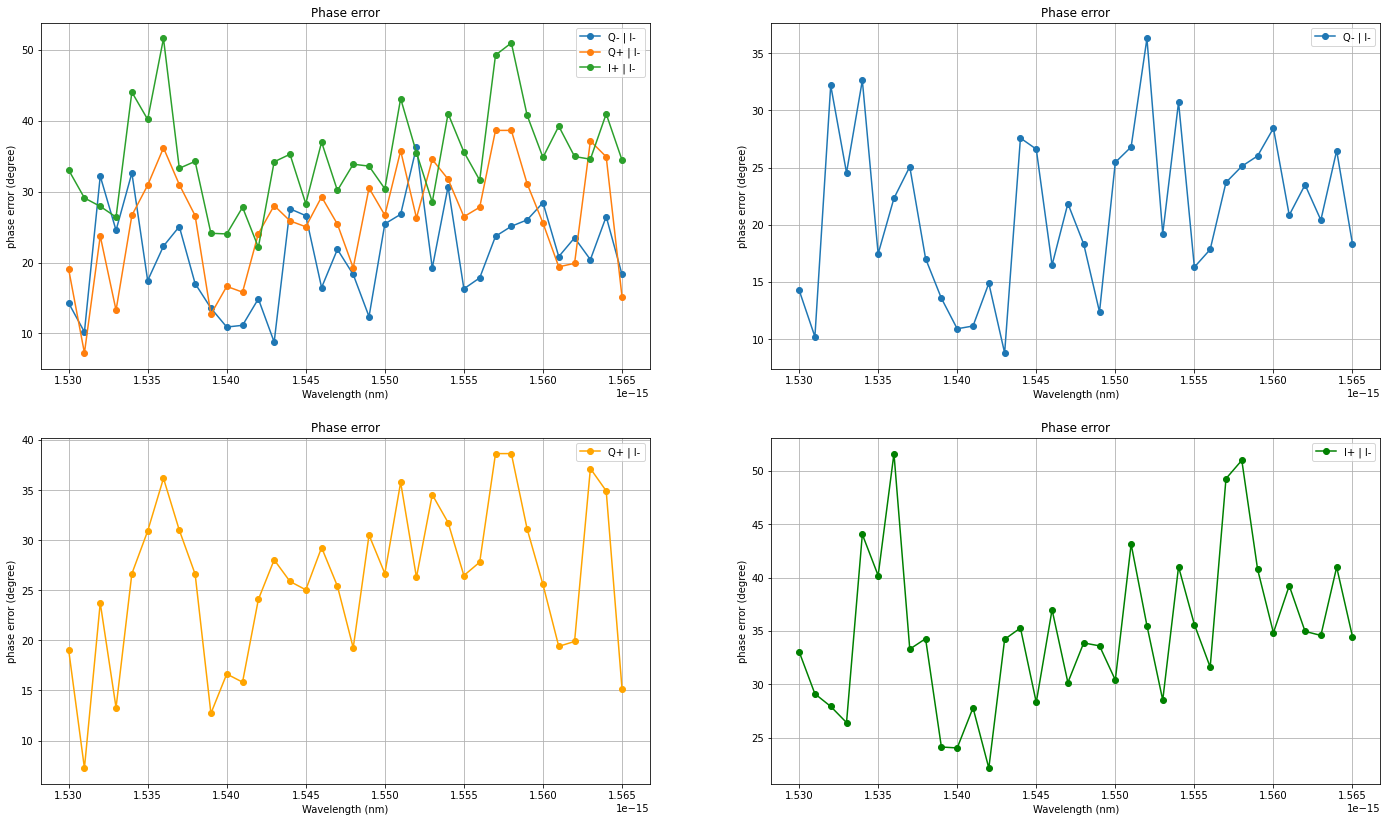

In [453]:
fig, ax= plt.subplots(2,2,figsize=(24,14))

ax[0][0].plot(CFreqArray*1e-9,PError,'-o', label='Q- | I-')
ax[0][0].plot(CFreqArray*1e-9,PError2,'-o',label='Q+ | I-')
ax[0][0].plot(CFreqArray*1e-9,PError3,'-o',label='I+ | I-')
ax[0][0].grid(True)
ax[0][0].legend()
ax[0][0].set_title('Phase error')
ax[0][0].set_xlabel('Wavelength (nm)')
ax[0][0].set_ylabel('phase error (degree)')

ax[0][1].plot(CFreqArray*1e-9,PError,'-o', label='Q- | I-')
ax[0][1].grid(True)
ax[0][1].legend()
ax[0][1].set_title('Phase error')
ax[0][1].set_xlabel('Wavelength (nm)')
ax[0][1].set_ylabel('phase error (degree)')

ax[1][0].plot(CFreqArray*1e-9,PError2,'-o',label='Q+ | I-', color='orange')
ax[1][0].grid(True)
ax[1][0].legend()
ax[1][0].set_title('Phase error')
ax[1][0].set_xlabel('Wavelength (nm)')
ax[1][0].set_ylabel('phase error (degree)')

ax[1][1].plot(CFreqArray*1e-9,PError3,'-o',label='I+ | I-', color='g')
ax[1][1].grid(True)
ax[1][1].legend()
ax[1][1].set_title('Phase error')
ax[1][1].set_xlabel('Wavelength (nm)')
ax[1][1].set_ylabel('phase error (degree)')

## Data Analysis

Pre-Processed


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79
IN,3.5620e+01,2.4722e+01,-6.3846e+01,-1.0564e+02,8.7154e+01,2.4885e+01,-1.5590e+01,-5.2570e+01,-5.2817e+01,-6.3425e+01,1.0421e+02,9.3639e+01,-8.1705e+01,-1.2084e+02,-2.3427e+00,1.1812e+02,7.0940e+01,-1.9720e+00,4.7309e+01,5.2950e+00,-5.4942e+00,-5.6518e+01,-9.3590e+01,-3.0404e+01,-9.5021e+01,1.5301e+02,-5.8394e+01,-8.2393e+01,-2.7306e+02,7.6260e+01,6.5532e+01,-6.6965e+01,-5.4977e+01,6.0844e+01,-1.0003e+00,1.1051e+02,5.6863e+00,-1.1395e+02,-2.2327e+01,-3.2986e+01,-1.2665e+02,-7.9010e+01,-1.4290e+02,-2.4313e+01,-7.9127e+00,1.2351e+02,-1.0810e+02,-1.1840e+02,5.1346e+01,3.9227e+01,1.2939e+02,-1.7155e+02,-5.0817e+01,-1.1221e+02,6.7479e+00,1.2177e+02,-1.0636e+02,-4.7755e+01,1.2129e+02,1.1040e+02,9.8421e+01,-4.6263e+01,-1.2814e+02,1.2496e+01,1.5674e+02,4.6307e+01,1.2166e+02,2.4685e+01,1.3871e+01,3.0858e+00,1.0045e+02,-1.5173e+02,6.9250e-02,1.1234e+02,3.1122e+01,1.1535e+02,-7.1001e+01,-8.3202e+01,-9.3669e+01,1.0431e+02
IP,3.2469e+01,2.1550e+01,-6.7406e+01,-3.6104e+01,-9.5158e+01,-5.0339e+00,1.0899e+02,-1.0889e+02,-5.6170e+01,1.1318e+02,1.0079e+02,9.0191e+01,-8.6327e+01,5.3292e+01,-1.0853e+01,8.0492e+01,1.8094e+01,-4.4934e+01,4.0480e+01,1.4861e+00,-9.3523e+00,-6.1823e+01,-1.5376e+02,-3.5518e+01,7.9511e+01,-3.4910e+01,-1.1709e+02,-8.6907e+01,-9.7555e+01,7.1795e+01,6.1104e+01,-7.4665e+01,-6.2265e+01,-1.2636e+02,-1.2364e+01,1.0268e+02,-1.4180e+01,4.8667e+00,-2.7776e+01,1.4141e+02,1.3299e+02,-8.3822e+01,2.7965e+01,-3.4166e+01,-1.7848e+01,1.1911e+02,-1.1462e+02,5.4894e+01,4.4468e+01,3.2196e+01,9.7621e+01,2.6804e+02,-5.6664e+01,5.6467e+01,-6.1053e+00,1.0027e+02,8.5561e+00,-5.5742e+01,-6.6795e+01,1.3074e+02,8.5639e+01,-5.2061e+01,7.0902e+01,-2.1456e+01,-3.8135e+01,3.7116e+01,-1.5375e+02,1.5377e+01,4.5399e+00,5.9859e+01,6.1994e+01,1.2665e+01,-1.0288e+01,1.1125e+02,1.7363e+01,1.3439e+02,-1.1824e+02,8.5928e+01,7.5284e+01,4.1449e+01
QN,1.2486e+02,1.1393e+02,-7.6963e+01,-8.9641e+01,-4.7532e+01,9.6548e+01,5.7836e+01,-1.3302e+02,3.6145e+01,2.5476e+01,1.3036e+01,2.3957e+00,-8.3482e+00,-2.3618e+01,2.7755e+02,4.3681e+01,1.6265e+02,-8.8645e+01,-7.5513e+01,-8.6381e+01,8.2780e+01,-1.0803e+02,-1.1882e+02,-2.9292e+01,-6.5183e+01,2.8826e+01,-1.6377e+02,5.4443e+00,-5.2697e+00,-1.6000e+01,1.5323e+02,-3.7587e+01,-1.2799e+02,-1.2889e+01,1.0448e+02,4.4207e+01,-1.5814e+01,7.5565e+01,6.4799e+01,5.4061e+01,4.3341e+01,1.1873e+02,-6.3910e+00,-4.2242e+01,2.9687e-01,-1.0565e+01,-2.1466e+01,-3.1887e+01,-4.2275e+01,-5.4524e+01,1.1490e+02,-3.1542e+01,-1.1786e+02,5.4933e+00,-5.6030e+01,5.5287e+01,-1.3091e+02,-1.4195e+02,2.7061e+01,1.6127e+01,-2.6096e+02,1.2702e+02,1.4935e+01,-2.7015e+01,1.4230e+02,1.3164e+02,-5.9166e+01,-7.0024e+01,9.9147e+01,8.8340e+01,7.7559e+01,1.6723e+01,-4.4032e+01,-1.0435e+02,-2.0201e+01,2.4260e+01,1.3712e+01,1.4175e+00,-9.1211e+00,-1.9690e+01
QP,-5.2131e+01,1.1699e+02,-1.5129e+02,-1.3036e+01,-4.9930e+01,-6.5800e+01,7.6839e+01,-1.4021e+02,-1.4042e+02,2.8862e+01,1.6401e+01,-6.3184e+02,2.7614e+02,-2.6667e+01,9.7545e+01,5.6360e+01,1.7503e+02,1.4448e+01,-4.1916e+01,9.7623e+01,8.6839e+01,-1.4576e+02,6.5652e+01,-3.9592e+01,1.0142e+02,6.3483e+01,-1.4598e+02,9.8483e+00,-8.7493e-01,-1.1609e+01,-2.2370e+01,-1.5738e+02,-1.4219e+01,-5.1224e+01,-6.9765e+01,4.6134e+01,-1.6469e+02,-2.2367e+01,-1.1053e+02,5.8748e+01,4.8586e+01,-3.8576e+04,-2.6606e+01,1.1679e+02,7.9970e+01,3.4833e+01,-1.6720e+01,-2.7188e+01,-3.7604e+01,1.3015e+02,1.5991e+01,2.6712e+02,-3.4982e+01,-2.3164e+00,1.3098e+02,2.1823e+01,-2.0930e+01,4.2814e+01,3.1807e+01,4.9053e+01,-2.6152e+02,2.2490e+02,-4.1245e+01,9.8137e+01,6.2074e+01,1.3634e+02,-5.4561e+01,-6.5552e+01,-7.6496e+01,3.3783e+01,-2.6166e+02,-4.1879e+01,-6.2832e+01,5.7063e+01,5.5248e+01,1.9028e+01,-1.7010e+01,5.6653e+00,-4.8918e+00,1.2803e+01
Wavelength,1.5603e-06,1.5605e-06,1.5607e-06,1.5610e-06,1.5612e-06,1.5615e-06

Processed


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79
IN,3.5620e+01,2.4722e+01,-6.3846e+01,-1.0564e+02,8.7154e+01,2.4885e+01,-1.5590e+01,-5.2570e+01,-5.2817e+01,-6.3425e+01,-7.5793e+01,-8.6361e+01,-8.1705e+01,-1.2084e+02,1.7766e+02,1.1812e+02,-1.0906e+02,1.7803e+02,4.7309e+01,-1.7471e+02,1.7451e+02,-5.6518e+01,-9.3590e+01,-3.0404e+01,-9.5021e+01,1.5301e+02,-5.8394e+01,9.7607e+01,-2.7306e+02,7.6260e+01,6.5532e+01,-6.6965e+01,1.2502e+02,6.0844e+01,-1.0003e+00,-6.9491e+01,-1.7431e+02,-1.1395e+02,-2.2327e+01,-3.2986e+01,-1.2665e+02,-7.9010e+01,-1.4290e+02,1.5569e+02,1.7209e+02,1.2351e+02,-1.0810e+02,-1.1840e+02,-1.2865e+02,-1.4077e+02,-5.0613e+01,-1.7155e+02,-5.0817e+01,-1.1221e+02,-1.7325e+02,1.2177e+02,7.3637e+01,1.3225e+02,1.2129e+02,1.1040e+02,-8.1579e+01,1.3374e+02,-1.2814e+02,-1.6750e+02,1.5674e+02,4.6307e+01,1.2166e+02,2.4685e+01,1.3871e+01,3.0858e+00,-7.9549e+01,-1.5173e+02,-1.7993e+02,1.1234e+02,3.1122e+01,1.1535e+02,-7.1001e+01,-8.3202e+01,-9.3669e+01,1.0431e+02
IP,-1.4753e+02,-1.5845e+02,1.1259e+02,-3.6104e+01,-9.5158e+01,-5.0339e+00,1.0899e+02,7.1109e+01,1.2383e+02,1.1318e+02,1.0079e+02,9.0191e+01,9.3673e+01,5.3292e+01,-1.0853e+01,8.0492e+01,1.8094e+01,1.3507e+02,-1.3952e+02,1.4861e+00,-9.3523e+00,1.1818e+02,-1.5376e+02,1.4448e+02,7.9511e+01,-3.4910e+01,6.2912e+01,-8.6907e+01,-9.7555e+01,-1.0820e+02,-1.1890e+02,1.0534e+02,-6.2265e+01,-1.2636e+02,1.6764e+02,1.0268e+02,1.6582e+02,4.8667e+00,1.5222e+02,1.4141e+02,1.3299e+02,9.6178e+01,2.7965e+01,-3.4166e+01,-1.7848e+01,-6.0890e+01,6.5376e+01,5.4894e+01,4.4468e+01,3.2196e+01,9.7621e+01,2.6804e+02,1.2334e+02,5.6467e+01,-6.1053e+00,-7.9727e+01,8.5561e+00,-5.5742e+01,-6.6795e+01,1.3074e+02,8.5639e+01,-5.2061e+01,7.0902e+01,1.5854e+02,-3.8135e+01,-1.4288e+02,-1.5375e+02,-1.6462e+02,-1.7546e+02,-1.2014e+02,6.1994e+01,1.2665e+01,-1.0288e+01,1.1125e+02,-1.6264e+02,1.3439e+02,-1.1824e+02,8.5928e+01,7.5284e+01,-1.3855e+02
QN,1.2486e+02,1.1393e+02,1.0304e+02,9.0359e+01,-4.7532e+01,-8.3452e+01,5.7836e+01,4.6979e+01,3.6145e+01,2.5476e+01,1.3036e+01,2.3957e+00,-8.3482e+00,-2.3618e+01,2.7755e+02,-1.3632e+02,1.6265e+02,9.1355e+01,-7.5513e+01,-8.6381e+01,-9.7220e+01,-1.0803e+02,-1.1882e+02,-2.9292e+01,-6.5183e+01,-1.5117e+02,-1.6377e+02,-1.7456e+02,1.7473e+02,1.6400e+02,1.5323e+02,1.4241e+02,-1.2799e+02,1.6711e+02,1.0448e+02,4.4207e+01,-1.5814e+01,7.5565e+01,6.4799e+01,5.4061e+01,4.3341e+01,1.1873e+02,-6.3910e+00,-4.2242e+01,2.9687e-01,-1.0565e+01,-2.1466e+01,-3.1887e+01,-4.2275e+01,-5.4524e+01,-6.5096e+01,1.4846e+02,-1.1786e+02,5.4933e+00,-5.6030e+01,-1.2471e+02,-1.3091e+02,-1.4195e+02,-1.5294e+02,-1.6387e+02,-2.6096e+02,1.2702e+02,-1.6507e+02,1.5298e+02,1.4230e+02,1.3164e+02,1.2083e+02,1.0998e+02,9.9147e+01,8.8340e+01,7.7559e+01,1.6723e+01,-4.4032e+01,-1.0435e+02,-2.0201e+01,2.4260e+01,1.3712e+01,1.4175e+00,-9.1211e+00,-1.9690e+01
QP,-5.2131e+01,-6.3012e+01,-1.5129e+02,1.6696e+02,1.3007e+02,-6.5800e+01,-1.0316e+02,-1.4021e+02,-1.4042e+02,-1.5114e+02,-1.6360e+02,-6.3184e+02,2.7614e+02,1.5333e+02,9.7545e+01,-1.2364e+02,1.7503e+02,-1.6555e+02,-4.1916e+01,9.7623e+01,8.6839e+01,-1.4576e+02,6.5652e+01,1.4041e+02,1.0142e+02,6.3483e+01,-1.4598e+02,9.8483e+00,-8.7493e-01,-1.1609e+01,-2.2370e+01,-1.5738e+02,1.6578e+02,1.2878e+02,-6.9765e+01,-1.3387e+02,-1.6469e+02,1.5763e+02,-1.1053e+02,-1.2125e+02,-1.3141e+02,-3.8576e+04,1.5339e+02,1.1679e+02,7.9970e+01,3.4833e+01,1.6328e+02,1.5281e+02,1.4240e+02,1.3015e+02,-1.6401e+02,2.6712e+02,1.4502e+02,1.7768e+02,1.3098e+02,2.1823e+01,1.5907e+02,4.2814e+01,3.1807e+01,-1.3095e+02,-2.6152e+02,2.2490e+02,1.3876e+02,9.8137e+01,6.2074e+01,-4.3659e+01,-5.4561e+01,-6.5552e+01,-7.6496e+01,3.3783e+01,-2.6166e+02,1.3812e+02,1.1717e+02,5.7063e+01,5.5248e+01,1.9028e+01,-1.7010e+01,-1.7433e+02,1.7511e+02,1.2803e+01
Wavelength,1.5603e-06,1.5605e-06,1.5607e-06,1.5610e-06,1.5612e-06,1.5615e-06,1.561

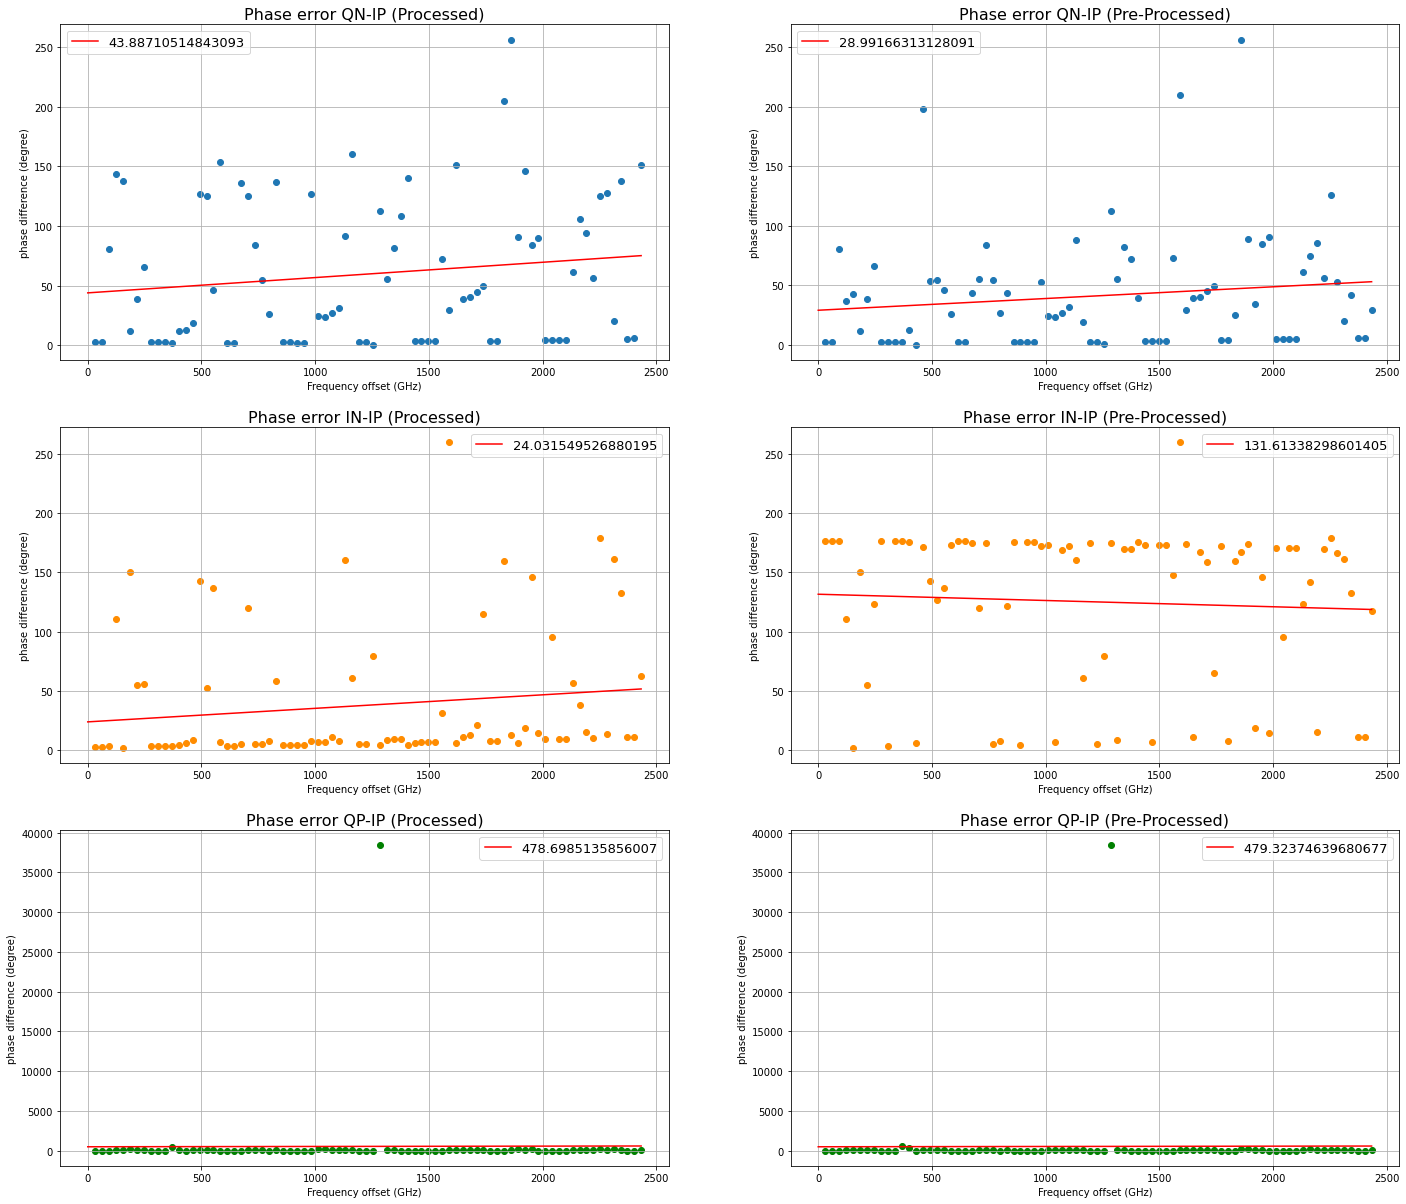

In [449]:
jindex = 0 # Index
lineArray = np.linspace(0,FreqDebug[-1,jindex],10)

PTestPhaseArray = abs(180 - abs(DebugQN[:,jindex] - (DebugIP[:,jindex]+90) ))
PTestPhaseArray2 = abs(180 - abs(DebugIN[:,jindex] - DebugIP[:,jindex] ))
PTestPhaseArray3 = abs(180 - abs(DebugQP[:,jindex]+90 - (DebugIP[:,jindex]) ))

TestPhaseArray = abs(90 - abs(PreDebugQN[:,jindex] - PreDebugIP[:,jindex]))
TestPhaseArray2 = abs(180 - abs(PreDebugIN[:,jindex] - PreDebugIP[:,jindex]))
TestPhaseArray3 = abs(90 - abs(PreDebugQP[:,jindex] - PreDebugIP[:,jindex]))

TestPhaseArray[13] = 0

linepoly = np.polyfit(FreqDebug[:,jindex]*1e-9,PTestPhaseArray,1)
fig, ax= plt.subplots(3,2,figsize=(24,21))
ax[0][0].scatter(FreqDebug[:,jindex]*1e-9,PTestPhaseArray)
ax[0][0].plot(lineArray*1e-9,linepoly[1]+linepoly[0]*lineArray*1e-9,color='red',label=str(linepoly[1]))
ax[0][0].grid(True)
ax[0][0].set_title('Phase error QN-IP (Processed)', fontsize=16)
ax[0][0].set_xlabel('Frequency offset (GHz)')
ax[0][0].set_ylabel('phase difference (degree)')
ax[0][0].legend(fontsize=13)

linepoly = np.polyfit(FreqDebug[:,jindex]*1e-9,TestPhaseArray,1)
ax[0][1].scatter(FreqDebug[:,jindex]*1e-9,TestPhaseArray)
ax[0][1].plot(lineArray*1e-9,linepoly[1]+linepoly[0]*lineArray*1e-9,color='red',label=str(linepoly[1]))
ax[0][1].grid(True)
ax[0][1].set_title('Phase error QN-IP (Pre-Processed)', fontsize=16)
ax[0][1].set_xlabel('Frequency offset (GHz)')
ax[0][1].set_ylabel('phase difference (degree)')
ax[0][1].legend(fontsize=13)

linepoly = np.polyfit(FreqDebug[:,jindex]*1e-9,PTestPhaseArray2,1)
ax[1][0].scatter(FreqDebug[:,jindex]*1e-9,PTestPhaseArray2, color='darkorange')
ax[1][0].plot(lineArray*1e-9,linepoly[1]+linepoly[0]*lineArray*1e-9,color='red',label=str(linepoly[1]))
ax[1][0].grid(True)
ax[1][0].set_title('Phase error IN-IP (Processed)', fontsize=16)
ax[1][0].set_xlabel('Frequency offset (GHz)')
ax[1][0].set_ylabel('phase difference (degree)')
ax[1][0].legend(fontsize=13)

linepoly = np.polyfit(FreqDebug[:,jindex]*1e-9,TestPhaseArray2,1)
ax[1][1].scatter(FreqDebug[:,jindex]*1e-9,TestPhaseArray2, color='darkorange')
ax[1][1].plot(lineArray*1e-9,linepoly[1]+linepoly[0]*lineArray*1e-9,color='red',label=str(linepoly[1]))
ax[1][1].grid(True)
ax[1][1].set_title('Phase error IN-IP (Pre-Processed)', fontsize=16)
ax[1][1].set_xlabel('Frequency offset (GHz)')
ax[1][1].set_ylabel('phase difference (degree)')
ax[1][1].legend(fontsize=13)

linepoly = np.polyfit(FreqDebug[:,jindex]*1e-9,PTestPhaseArray3,1)
ax[2][0].scatter(FreqDebug[:,jindex]*1e-9,PTestPhaseArray3, color='green')
ax[2][0].plot(lineArray*1e-9,linepoly[1]+linepoly[0]*lineArray*1e-9,color='red',label=str(linepoly[1]))
ax[2][0].grid(True)
ax[2][0].set_title('Phase error QP-IP (Processed)', fontsize=16)
ax[2][0].set_xlabel('Frequency offset (GHz)')
ax[2][0].set_ylabel('phase difference (degree)')
ax[2][0].legend(fontsize=13)

linepoly = np.polyfit(FreqDebug[:,jindex]*1e-9,TestPhaseArray3,1)
ax[2][1].scatter(FreqDebug[:,jindex]*1e-9,TestPhaseArray3, color='green')
ax[2][1].plot(lineArray*1e-9,linepoly[1]+linepoly[0]*lineArray*1e-9,color='red',label=str(linepoly[1]))
ax[2][1].grid(True)
ax[2][1].set_title('Phase error QP-IP (Pre-Processed)', fontsize=16)
ax[2][1].set_xlabel('Frequency offset (GHz)')
ax[2][1].set_ylabel('phase difference (degree)')
ax[2][1].legend(fontsize=13)

def highlight_rows(s):
    return 'color: % s' % 'yellow'

dataFrame = pd.DataFrame(np.array([PreDebugIN[:,jindex], 
                                   PreDebugIP[:,jindex], 
                                   PreDebugQN[:,jindex],
                                   PreDebugQP[:,jindex],
                                   LaserArray,
                                   
                                   abs(PreDebugQN[:,jindex] - PreDebugIP[:,jindex]),
                                   abs(PreDebugIN[:,jindex] - PreDebugIP[:,jindex]),
                                   abs(PreDebugQP[:,jindex] - PreDebugIP[:,jindex])]),
                                 index=['IN', 'IP', 'QN', 'QP', "Wavelength", "QN - IP", "IN - IP", "QP - IP"])
print("Pre-Processed")
display(dataFrame.style \
  .set_properties(**{
    'font-size': '12pt',
  }) \
 .format("{:.4e}") \
 .applymap(highlight_rows, subset = pd.IndexSlice[['Wavelength'],:]))

dataFrame = pd.DataFrame(np.array([DebugIN[:,jindex], 
                                   DebugIP[:,jindex], 
                                   DebugQN[:,jindex],
                                   DebugQP[:,jindex],
                                   LaserArray,
                                   
                                   abs(DebugQN[:,jindex] - (DebugIP[:,jindex]) ),
                                   abs(DebugIN[:,jindex] - DebugIP[:,jindex] ),
                                   abs(DebugQP[:,jindex] - (DebugIP[:,jindex]) )]),
                                 index=['IN', 'IP', 'QN', 'QP', "Wavelength", "QN - IP", "IN - IP", "QP - IP"])
print("Processed")
display(dataFrame.style \
  .set_properties(**{
    'font-size': '12pt',
  }) \
 .format("{:.4e}") \
 .applymap(highlight_rows, subset = pd.IndexSlice[['Wavelength'],:]))

Text(0.5, 0.98, 'Phase Distribuition (Pre-processed)')

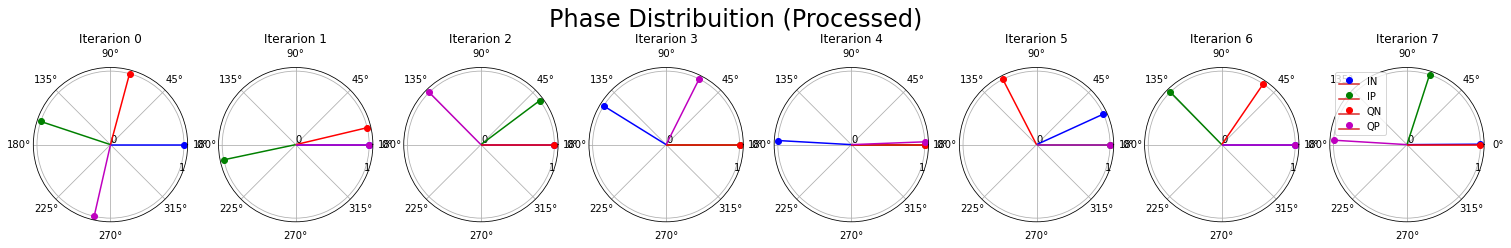

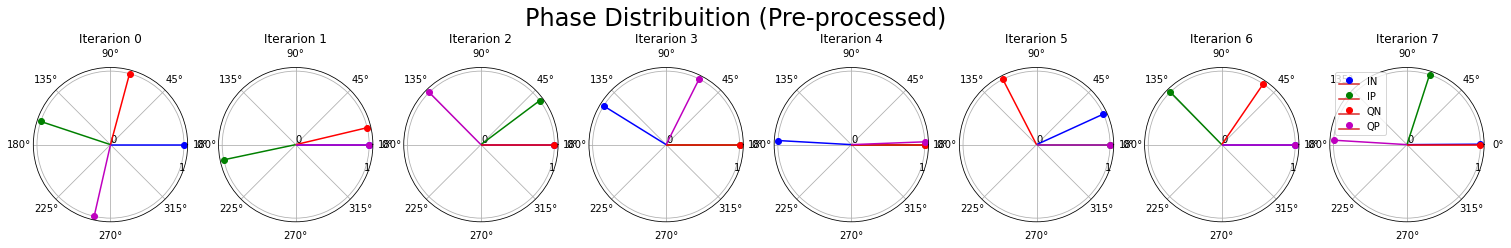

In [350]:
import warnings
#warnings.filterwarnings("ignore")

jindex = 0 # Index
wvArray = np.arange(0,8,1) # Wavelengths indexes array to display
r = np.ones(4)

fig, ax = plt.subplots(1,len(wvArray),subplot_kw={'projection': 'polar'},figsize=(26,4))
for i in range(len(wvArray)):
    ax[i].stem(DebugIN[wvArray[0]+i , jindex]*np.pi/180, 1, 'b', markerfmt='bo',label='IN')
    ax[i].stem(DebugIP[wvArray[0]+i , jindex]*np.pi/180, 1, 'g', markerfmt='go',label='IP')
    ax[i].stem(DebugQN[wvArray[0]+i , jindex]*np.pi/180, 1, 'r', markerfmt='ro',label='QN')
    ax[i].stem(DebugQP[wvArray[0]+i , jindex]*np.pi/180, 1, 'm', markerfmt='mo',label='QP')
    ax[i].set_rticks([0, 1])  # Less radial ticks
    ax[i].set_rlabel_position(-22.5)  # Move radial labels away from plotted line
    ax[i].grid(True)
    ax[i].set_title("Iterarion " + str(i + wvArray[0]))
ax[i].legend()
fig.suptitle('Phase Distribuition (Processed)', fontsize=24)

fig, ax = plt.subplots(1,len(wvArray),subplot_kw={'projection': 'polar'},figsize=(26,4))
for i in range(len(wvArray)):
    ax[i].stem(PreDebugIN[wvArray[0]+i , jindex]*np.pi/180, 1, 'b', markerfmt='bo',label='IN')
    ax[i].stem(PreDebugIP[wvArray[0]+i , jindex]*np.pi/180, 1, 'g', markerfmt='go',label='IP')
    ax[i].stem(PreDebugQN[wvArray[0]+i , jindex]*np.pi/180, 1, 'r', markerfmt='ro',label='QN')
    ax[i].stem(PreDebugQP[wvArray[0]+i , jindex]*np.pi/180, 1, 'm', markerfmt='mo',label='QP')
    ax[i].set_rticks([0, 1])  # Less radial ticks
    ax[i].set_rlabel_position(-22.5)  # Move radial labels away from plotted line
    ax[i].grid(True)
    ax[i].set_title("Iterarion " + str(i + wvArray[0]))
ax[i].legend()
fig.suptitle('Phase Distribuition (Pre-processed)', fontsize=24)

2


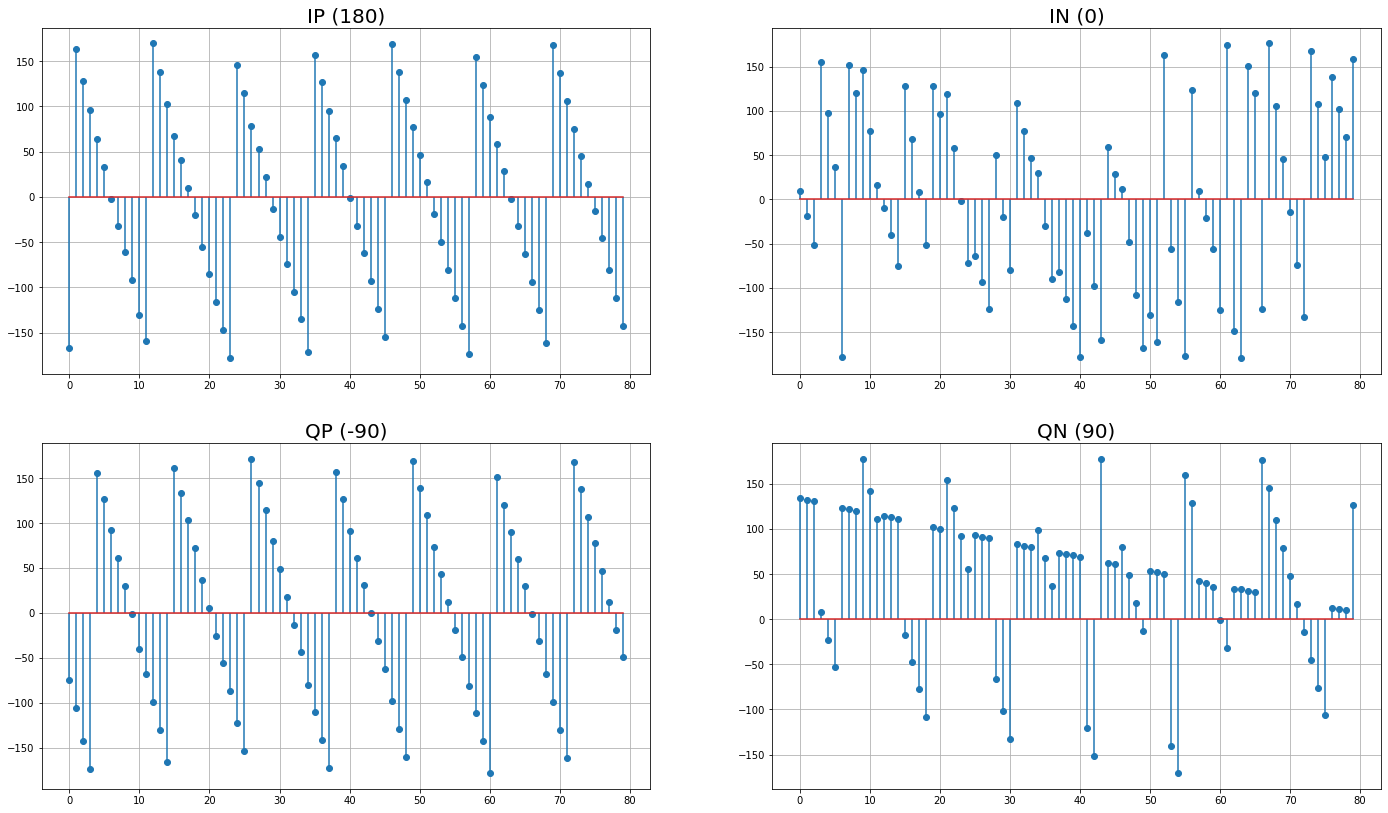

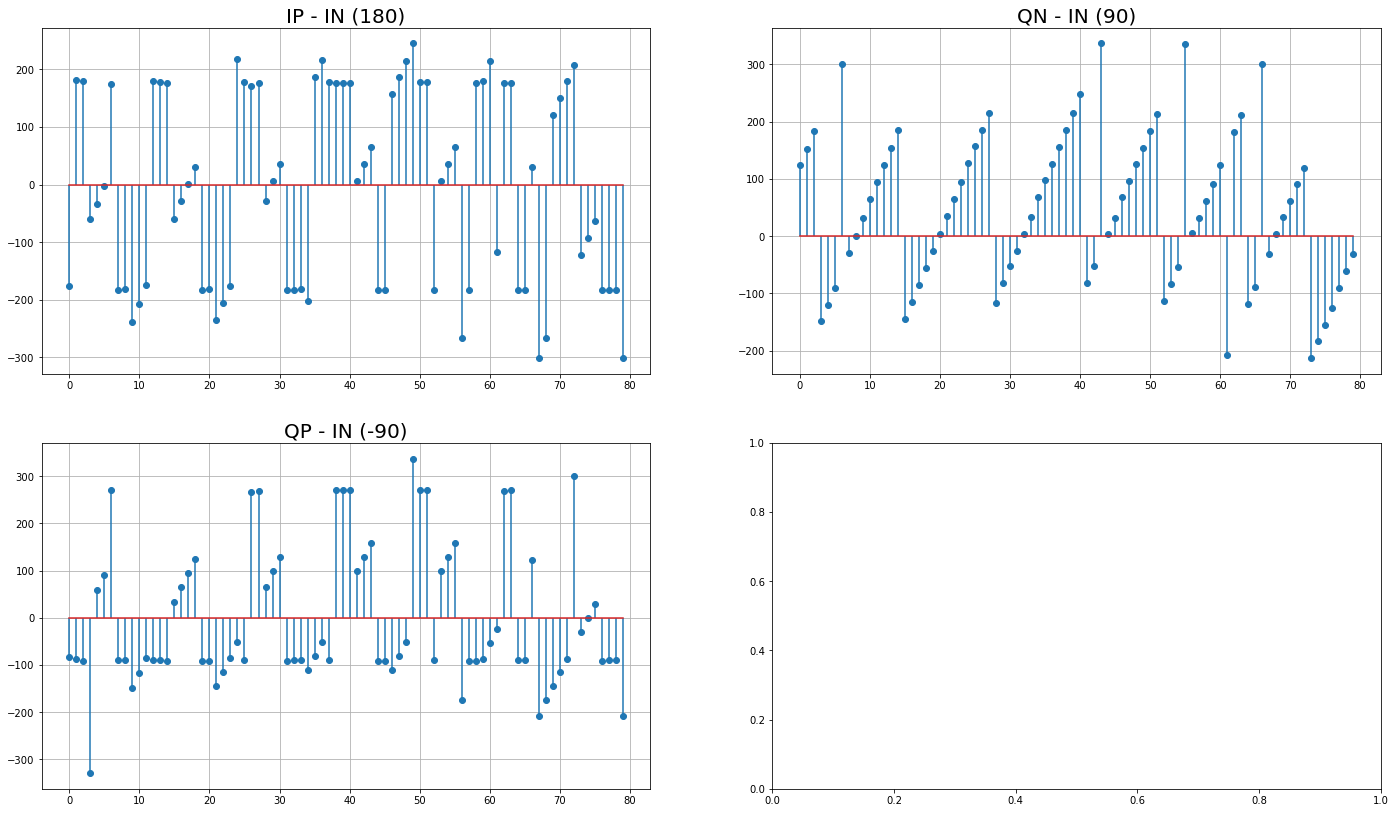

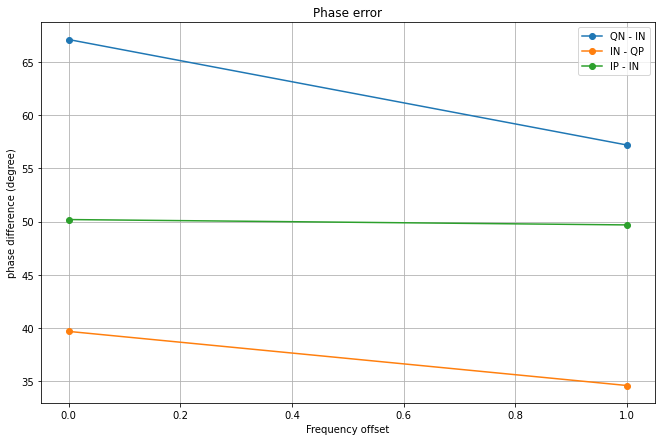

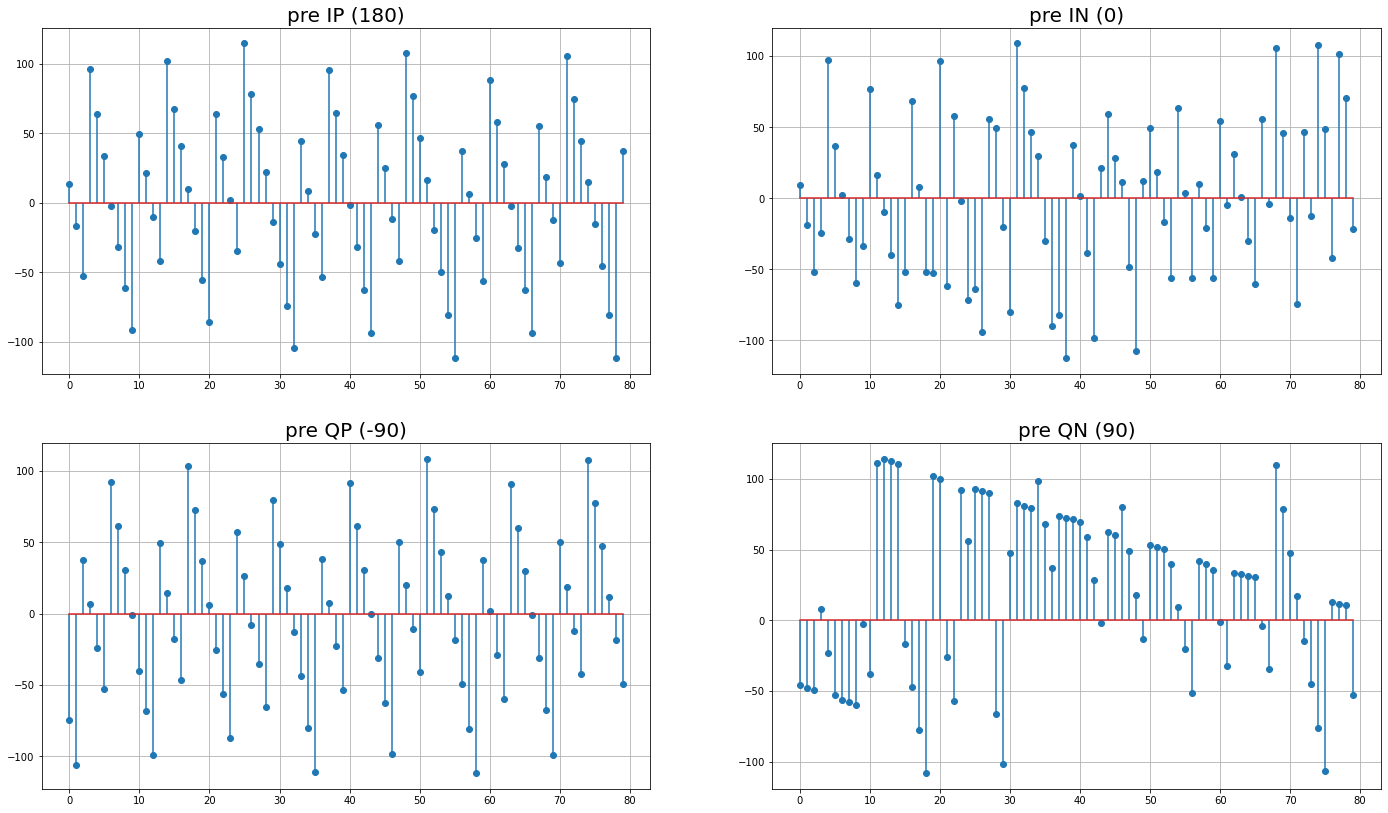

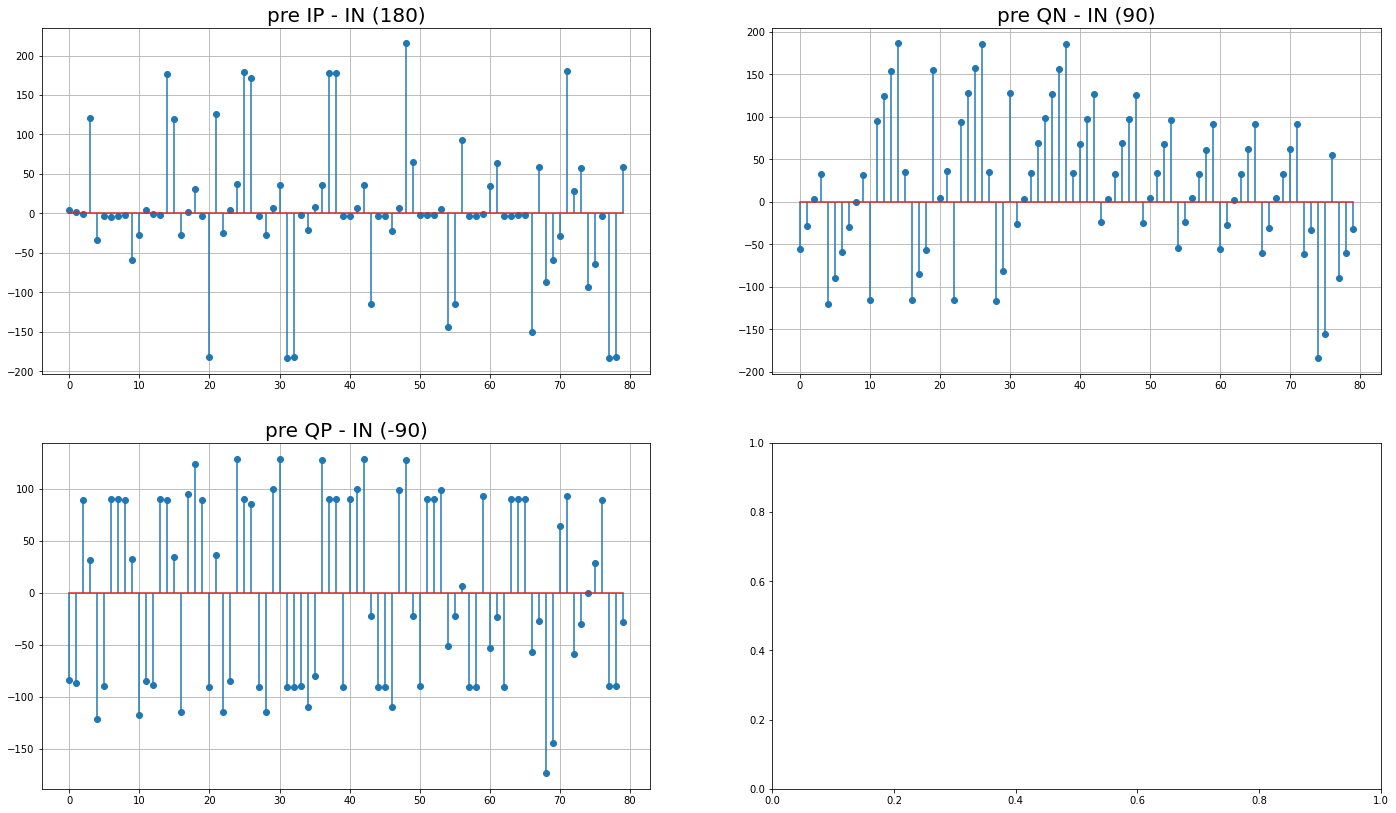

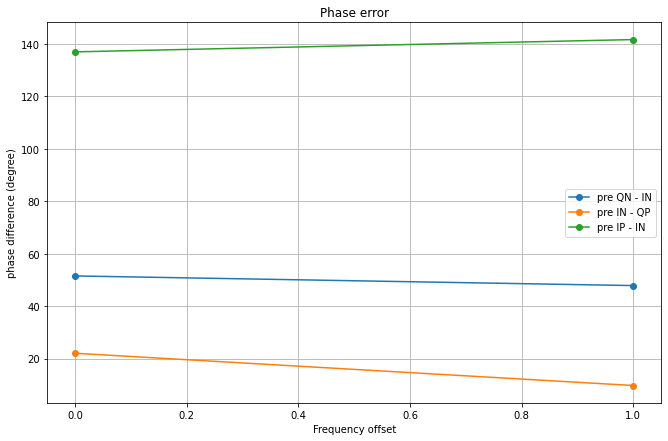

In [245]:
#DebugIP[i,j] 
#DebugIN[i,j]
#DebugQP[i,j]
#DebugQN[i,j]

xarray = np.arange(0,len(DebugIP[:,0]),1)
farray = np.arange(0,len(DebugIP[0,:]),1)

PErrorT1 = np.zeros(len(DebugIP[0,:]))
PErrorT2 = np.zeros(len(DebugIP[0,:]))
PErrorT3 = np.zeros(len(DebugIP[0,:]))

print(len(DebugIP[0,:]))
jindex = 1 # Index

fig, ax= plt.subplots(2,2,figsize=(24,14))
ax[0][0].stem(xarray,DebugIP[:,jindex])
ax[0][0].grid(True)
ax[0][0].set_title("IP (180)", fontsize=20)

ax[0][1].stem(xarray,DebugIN[:,jindex])
ax[0][1].grid(True)
ax[0][1].set_title("IN (0)", fontsize=20)

ax[1][0].stem(xarray,DebugQP[:,jindex])
ax[1][0].grid(True)
ax[1][0].set_title("QP (-90)", fontsize=20)

ax[1][1].stem(xarray,DebugQN[:,jindex])
ax[1][1].grid(True)
ax[1][1].set_title("QN (90)", fontsize=20)


fig, ax= plt.subplots(2,2,figsize=(24,14))
ax[0][0].stem(xarray, DebugIP[:,jindex] - DebugIN[:,jindex])
ax[0][0].grid(True)
ax[0][0].set_title("IP - IN (180)", fontsize=20)

ax[0][1].stem(xarray, DebugQN[:,jindex] - DebugIN[:,jindex])
ax[0][1].grid(True)
ax[0][1].set_title("QN - IN (90)", fontsize=20)

ax[1][0].stem(xarray, DebugQP[:,jindex] - DebugIN[:,jindex])
ax[1][0].grid(True)
ax[1][0].set_title("QP - IN (-90)", fontsize=20)

for j in range(len(DebugIP[0,:])):
    PhaseArrayT1 = np.zeros(len(DebugIP[:,0]))
    PhaseArrayT2 = np.zeros(len(DebugIP[:,0]))
    PhaseArrayT3 = np.zeros(len(DebugIP[:,0]))
    for i in range(len(DebugIP[:,0])):

        PhaseArrayT1[i] = abs(90 - abs(DebugQN[i,j] - DebugIN[i,j]))
        PhaseArrayT2[i] = abs(90 - abs(DebugIN[i,j] - DebugQP[i,j]))
        PhaseArrayT3[i] = abs(180 - abs(DebugIP[i,j] - DebugIN[i,j]))

    linepolyT1 = np.polyfit(xarray,PhaseArrayT1,1)
    linepolyT2 = np.polyfit(xarray,PhaseArrayT2,1)
    linepolyT3 = np.polyfit(xarray,PhaseArrayT3,1)
    PErrorT1[j] = linepolyT1[1]
    PErrorT2[j] = linepolyT2[1]
    PErrorT3[j] = linepolyT3[1]

fig = plt.figure(figsize = (11, 7))
plt.plot(farray,PErrorT1,'-o', label='QN - IN')
plt.plot(farray,PErrorT2,'-o', label='IN - QP')
plt.plot(farray,PErrorT3,'-o', label='IP - IN')
plt.grid(True)
plt.title('Phase error')
plt.xlabel('Frequency offset')
plt.ylabel('phase difference (degree)')
plt.legend()

# Pre processing ------------------------------------------------------------

fig, ax= plt.subplots(2,2,figsize=(24,14))
ax[0][0].stem(xarray,PreDebugIP[:,jindex])
ax[0][0].grid(True)
ax[0][0].set_title("pre IP (180)", fontsize=20)

ax[0][1].stem(xarray,PreDebugIN[:,jindex])
ax[0][1].grid(True)
ax[0][1].set_title("pre IN (0)", fontsize=20)

ax[1][0].stem(xarray,PreDebugQP[:,jindex])
ax[1][0].grid(True)
ax[1][0].set_title("pre QP (-90)", fontsize=20)

ax[1][1].stem(xarray,PreDebugQN[:,jindex])
ax[1][1].grid(True)
ax[1][1].set_title("pre QN (90)", fontsize=20)


fig, ax= plt.subplots(2,2,figsize=(24,14))
ax[0][0].stem(xarray, PreDebugIP[:,jindex] - PreDebugIN[:,jindex])
ax[0][0].grid(True)
ax[0][0].set_title("pre IP - IN (180)", fontsize=20)

ax[0][1].stem(xarray, PreDebugQN[:,jindex] - PreDebugIN[:,jindex])
ax[0][1].grid(True)
ax[0][1].set_title("pre QN - IN (90)", fontsize=20)

ax[1][0].stem(xarray, PreDebugQP[:,jindex] - PreDebugIN[:,jindex])
ax[1][0].grid(True)
ax[1][0].set_title("pre QP - IN (-90)", fontsize=20)

for j in range(len(DebugIP[0,:])):
    PhaseArrayT1 = np.zeros(len(DebugIP[:,0]))
    PhaseArrayT2 = np.zeros(len(DebugIP[:,0]))
    PhaseArrayT3 = np.zeros(len(DebugIP[:,0]))
    for i in range(len(DebugIP[:,0])):

        PhaseArrayT1[i] = abs(90 - abs(PreDebugQN[i,j] - PreDebugIN[i,j]))
        PhaseArrayT2[i] = abs(90 - abs(PreDebugIN[i,j] - PreDebugQP[i,j]))
        PhaseArrayT3[i] = abs(180 - abs(PreDebugIP[i,j] - PreDebugIN[i,j]))

    linepolyT1 = np.polyfit(xarray,PhaseArrayT1,1)
    linepolyT2 = np.polyfit(xarray,PhaseArrayT2,1)
    linepolyT3 = np.polyfit(xarray,PhaseArrayT3,1)
    PErrorT1[j] = linepolyT1[1]
    PErrorT2[j] = linepolyT2[1]
    PErrorT3[j] = linepolyT3[1]

fig = plt.figure(figsize = (11, 7))
plt.plot(farray,PErrorT1,'-o', label='pre QN - IN')
plt.plot(farray,PErrorT2,'-o', label='pre IN - QP')
plt.plot(farray,PErrorT3,'-o', label='pre IP - IN')
plt.grid(True)
plt.title('Phase error')
plt.xlabel('Frequency offset')
plt.ylabel('phase difference (degree)')
plt.legend()
